In [82]:
import librosa
from annotations import Annotations
import matplotlib.pyplot as plt
import soundfile as sf
from units import TimeUnit
from scipy import signal,ndimage
from sklearn.neighbors import KNeighborsClassifier
from  birdnetlib import 


import numpy as np

In [29]:
training = Annotations("C:\\Users\\plaf\\Music\\ALAN_training\\annotations\\training\\", "raven")

In [30]:
training.load()

Reading tables: [--------------------------------------->] 100%
{'Hissing', 'Hissing_during feeding'}


In [31]:
training.map_labels("c:\\Users\\plaf\\Music\\ALAN_training\\annotations\\labels.json")


Changing labels: [--------------------------------------->] 100%
{'Tyto alba_Barn Owl hissing', 'Tyto alba_Barn Owl hissing during feeding'}


In [32]:
training.load_audio_paths("c:\\Users\\plaf\\Music\\ALAN_training\\audiofiles")

Retrieving audio paths: [--------------------------------------->] 100%


In [174]:


intensities = {}
kernel = [[-100]*10 + [100]*30 + [-100]*10]

for af_wrap in training.audio_files.values():
    af = af_wrap.audio_file
    y, sr = librosa.load(af.path, sr=None)
    seg_sorted = sorted(af_wrap.segments, key=lambda seg: seg.tstart)

    for i, seg in enumerate(seg_sorted):
        s = seg.centered_pad_to(TimeUnit(3))
        # s = seg

        istart = int(s.tstart.s * sr)
        iend = int(s.tend.s * sr)
        y_ = y[istart:iend]

        S = librosa.stft(y_, n_fft=2048)#[50:250]
        spec = librosa.amplitude_to_db(np.abs(S))
        # bpm = librosa.feature.rhythm.tempo(y=y_, sr=sr)
        # phase = np.angle(S)
        # o_env = librosa.onset.onset_strength(y=y[istart:iend], sr=sr)
        # times = librosa.times_like(o_env, sr=sr)
        # onset_frames = librosa.onset.onset_detect(onset_envelope=o_env, sr=sr)
        # double_fft = librosa.amplitude_to_db(np.abs(np.fft.fft(spec, n=512, axis=0)))
        # fig, ax = plt.subplots(nrows=2, sharex=True)
        # spec = signal.convolve(spec, kernel)
        # librosa.display.specshow(spec,
        #                         x_axis='time', y_axis='linear', ax=ax[0])
        # ax[0].set(title='Power spectrogram')
        # ax[0].label_outer()
        # ax[1].plot(times, o_env, label='Onset strength')
        # ax[1].vlines(times[onset_frames], 0, o_env.max(), color='r', alpha=0.9,
        #         linestyle='--', label='Onsets')
        # ax[1].legend()
        # break
        intensities.setdefault(seg.label, {}).setdefault("std", []).append(np.std(spec))
        intensities[seg.label].setdefault("mean", []).append(np.mean(spec))

        


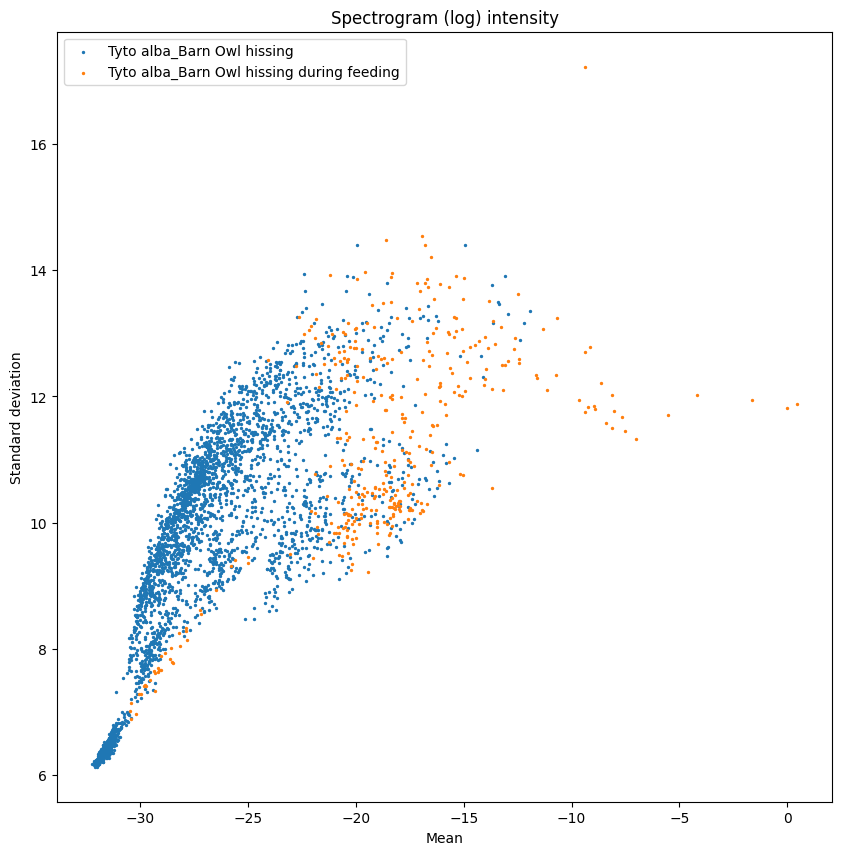

In [175]:
i = 0
fig = plt.figure(figsize=(10,10))

for label in intensities.keys():
    plt.scatter(intensities[label]["mean"], intensities[label]["std"], label=label, s=2)
    i+=1
plt.title("Spectrogram (log) intensity")
plt.xlabel("Mean")
plt.ylabel("Standard deviation")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

100_RueyresSansonnens_20230809_220000 0
5


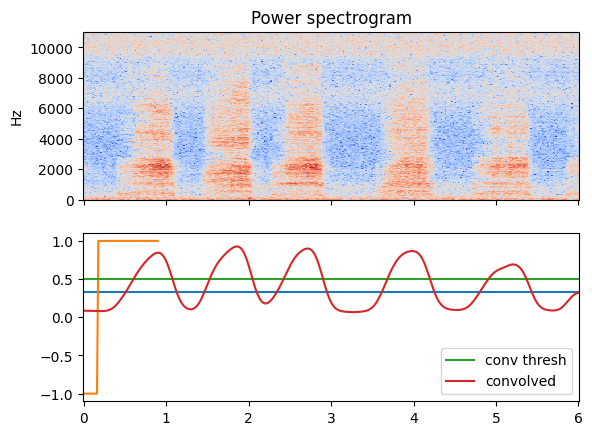

In [162]:
counts = {}


for k, af_wrap in training.audio_files.items():
    # af_wrap = training.audio_files["105_Sauge_20230621_220000"]

    af = af_wrap.audio_file

    y, sr = librosa.load(af.path, sr=None)
    len_s = .8
    n_fft = 2048
    hop_length = n_fft//4
    spec_cols = int((len_s * sr - n_fft) / hop_length)
    kernel = np.array([-1] * (spec_cols // 4) + [1] * spec_cols)
    seg_sorted = sorted(af_wrap.segments, key=lambda seg: seg.tstart)

    for i, seg in enumerate(seg_sorted):
        # seg = af_wrap.segments[2]
        s = seg.centered_pad_to(TimeUnit(6))
        if s.label == "":
            print("Label is None")
        # print(s.tstart, s.label)

        istart = int(s.tstart.s * sr)
        iend = int(s.tend.s * sr)
        y_ = y[istart:iend]

        S = librosa.stft(y_, n_fft=n_fft, hop_length=hop_length)#[50:250]
        spec = librosa.amplitude_to_db(np.abs(S))
        phase = np.angle(S)

        times = np.linspace(0, s.dur, spec.shape[1])

        spec_sum = np.sum(spec, axis=0)
        spec_sum = (spec_sum-np.min(spec_sum))/(np.max(spec_sum)-np.min(spec_sum))
        # conv = signal.convolve(spec_sum, kernel, mode="valid")
        # conv = ndimage.gaussian_filter1d(conv, 20)
        conv = ndimage.gaussian_filter1d(spec_sum, 5)
        # conv = spec_sum
        sspec = librosa.stft(conv, n_fft=128, hop_length=1)

        # dconv = np.diff(conv)
        # lmax = (dconv[:-1] > 0) & (dconv[1:] < 0) #& (dconv[:-1] - dconv[1:] > 1)

        thresh = (np.max(conv) + np.min(conv))/2
        # thresh = np.mean(conv)
        above_mean = conv > thresh
        new_call = np.diff(above_mean.astype(np.int8)) == 1
        count = np.sum(new_call)
        if True:
            print(k, i)
            # print(np.argmax(lmax))
            fig, ax = plt.subplots(nrows=2, sharex=True)
            librosa.display.specshow(spec, x_coords = times, x_axis='time', y_axis='linear', ax=ax[0])
            # librosa.display.specshow(sspec, x_coords = np.linspace(0, times[-1], (sspec.shape[1])), x_axis='time', y_axis='linear', ax=ax[0])
                              
            ax[0].set(title='Power spectrogram')
            ax[0].label_outer()
            # ax[1].plot( times, spec_sum, label='spec sum')
            ax[1].plot( times, len(times)*[np.median(spec_sum)])
            ax[1].plot(times[:len(kernel)], kernel)
            ax[1].plot( times, len(times)*[thresh], label="conv thresh")
            ax[1].plot(np.linspace(0, times[-1], len(conv)),  conv, label="convolved")
            # ax[1].scatter(np.linspace(0, times[-1], len(conv))[:-2][lmax], conv[:-2][lmax])

            print(count)
            ax[1].legend()
            plt.show()
            plt.close()
        counts.setdefault(seg.label, []).append(count)
        break
    break
    



KeyError: 1

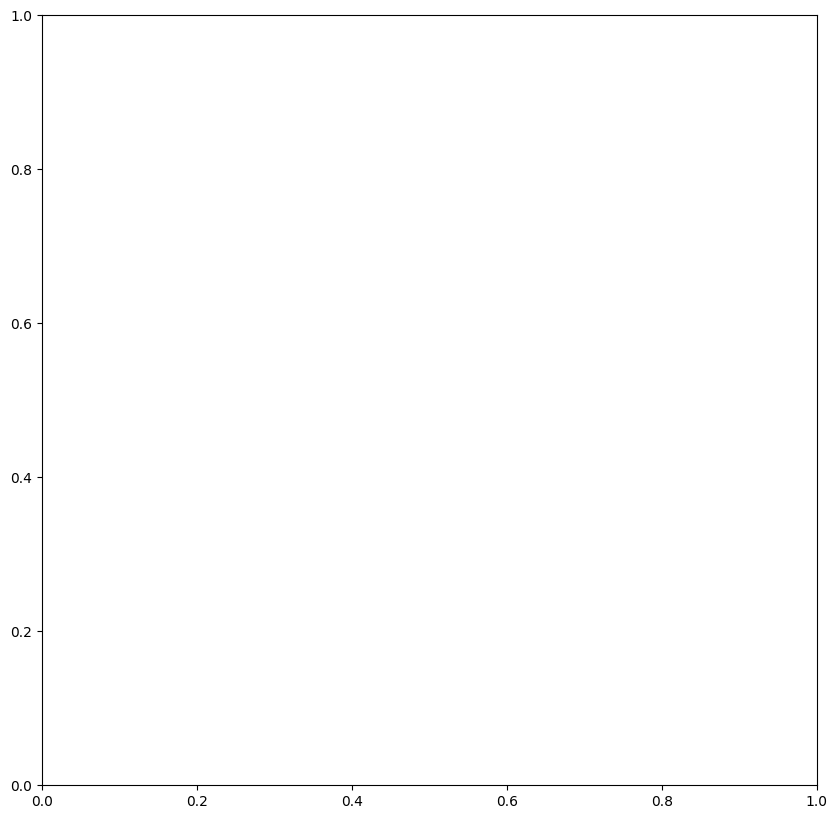

In [163]:
i = 0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()

for label in intensities.keys():
    ax.scatter(intensities[label][1], counts[label], label=label, s=2)
    i+=1
plt.title("Calls")
plt.xlabel("Mean spec power (log)")
plt.ylabel("Count")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

KeyError: 'Tyto alba_Barn Owl hissing during feeding'

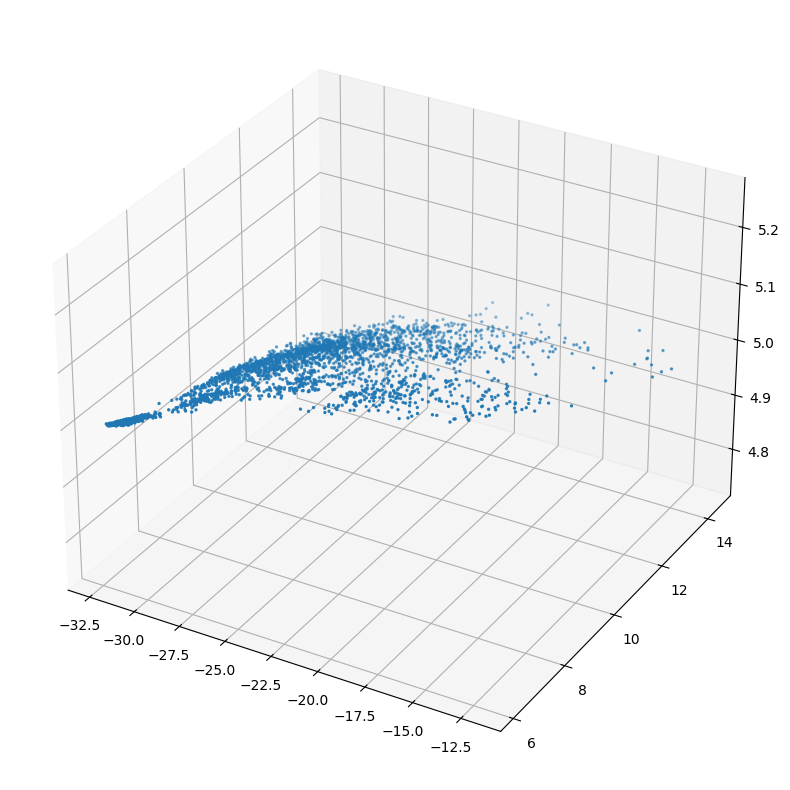

In [164]:
i = 0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
x = "mean"
y = "std"
for label in intensities.keys():
    ax.scatter(intensities[label][x], intensities[label][y], counts[label], label=label, s=2)
    i+=1
plt.title(f"Spectrogram {x} (log) intensity")
plt.xlabel(f"Spectrogram {y} (log) intensity")
plt.ylabel("Mean")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

In [ ]:
distances = {}
n_neighbors = 20
for k, af_wrap in training.audio_files.items():
    seg_sorted = sorted(af_wrap.segments, key=lambda seg: seg.tstart)

    for i, seg in enumerate(seg_sorted):
        neighbors = [np.abs(seg_sorted[j].tstart - seg_sorted[j-1].tstart) for j in range(max(1, i-n_neighbors), min(len(seg_sorted),i+n_neighbors))]
        mean_distance = np.mean(neighbors)
        distances.setdefault(seg.label, []).append(mean_distance)
        # distances[seg.label][-1] **= 2

    

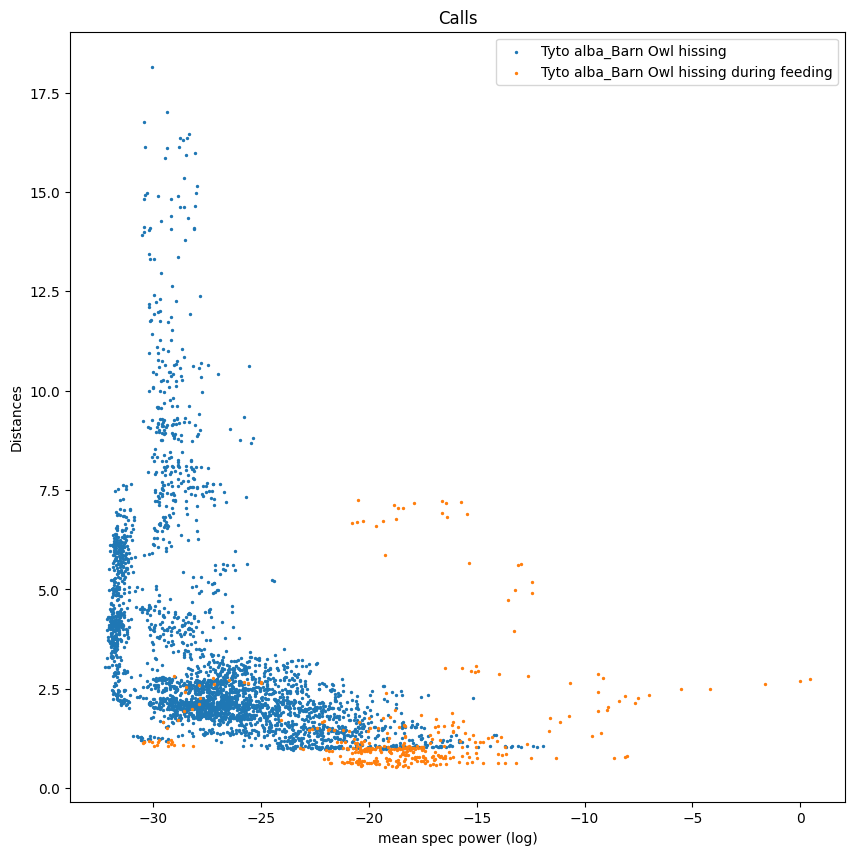

In [176]:
i = 0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot()
x = "mean"
for label in intensities.keys():
    ax.scatter(intensities[label][x], distances[label], label=label, s=2)
    i+=1
plt.title("Calls")
plt.xlabel(f"{x} spec power (log)")
plt.ylabel("Distances")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

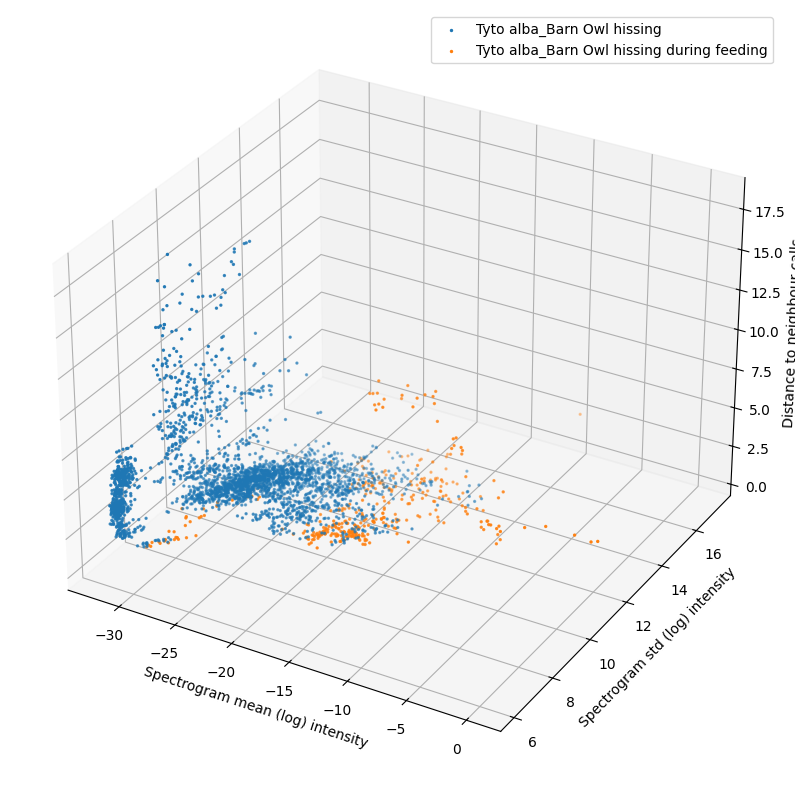

In [177]:
i = 0
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(projection='3d')
x = "mean"
y = "std"
for label in intensities.keys():
    ax.scatter(intensities[label][x], intensities[label][y], distances[label], label=label, s=2)
    i+=1
plt.xlabel(f"Spectrogram {x} (log) intensity")
plt.ylabel(f"Spectrogram {y} (log) intensity")
ax.set_zlabel("Distance to neighbour calls")
plt.legend()
# plt.xlim([0,1])
# plt.ylim([0,2.5])
plt.show()

In [191]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from joblib import dump, load



In [198]:

rf = RandomForestClassifier()
n_segs = [len(intensities[label]["mean"]) for label in intensities.keys()]
tot_n_segs = sum(n_segs)
X = np.zeros((tot_n_segs, 3), dtype=np.float64)
y = np.zeros((tot_n_segs,), dtype=np.int8)

prev_n = 0
for i, (n, label) in enumerate(zip(n_segs, intensities.keys())):

    X[prev_n:prev_n + n, 0] = intensities[label]["mean"]
    X[prev_n:prev_n + n, 1] = intensities[label]["std"]
    X[prev_n:prev_n + n, 2] = distances[label]
    y[prev_n:prev_n + n] = i
    prev_n = n

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.5, random_state=42)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

diff = y_test - y_pred

fp = diff == -1
fn = diff == 1
t = (diff == 0)
tp = t & y_test == 1
tn = t & y_test == 0

fp_n = np.sum(fp)
fn_n = np.sum(fn)
t_n = np.sum(t)
tp_n = np.sum(tp)
tn_n = np.sum(tn)

print(fp_n, fn_n, len(y_test))
print("Precision:", tp_n/(tp_n + fp_n))
print("Recall:", tp_n/(tp_n + fn_n))

16 39 1699
Precision: 0.7891891891891892
Recall: 0.7891891891891892


In [192]:
dump(rf, "..\\Documents\\rf.joblib")


['..\\Documents\\rf.joblib']

In [194]:
rf = load("..\\Documents\\rf.joblib")
y_pred = rf.predict(X_test)

diff = y_test - y_pred

fp = diff == -1
fn = diff == 1

fp_n = np.sum(fp)
fn_n = np.sum(fn)

print(fp_n, fn_n, len(y_test))

6 9 680
